In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
import sys
import rich
import pickle


import xobjects as xo
import xtrack as xt
import xpart as xp

sys.path.append('../')
import BBStudies.Tracking.XsuitePlus as xPlus
import BBStudies.Tracking.InteractionPoint as inp
import BBStudies.Physics.Detuning as dtune
import BBStudies.Physics.Base as phys
import BBStudies.Plotting.BBPlots as bbplt
import BBStudies.Physics.Constants as cst


LINEFOLDER   = '../Data/Lines/'
SURVEYFOLDER = '../Data/Surveys/'
df_columns = ['name', 's', 'x', 'px', 'y', 'py', 'zeta', 'delta', 'ptau', 'betx', 'bety', 'alfx', 'alfy', 'gamx', 'gamy', 'dx', 'dpx', 'dy', 'dpy', 'mux', 'muy', 'qx', 'qy', 'qs', 'dqx', 'dqy']


line   = {}
twiss  = {}
survey = {}

# Importing twiss
for seq in ['lhcb1','lhcb4']:
    _beam = seq[-2:]
    
    # Importing Line
    line[_beam] = xPlus.importLine(LINEFOLDER + f'line_opticsfile32_{seq}.json')
    
    # Importing twiss and tracker
    if _beam == 'b1':
        tracker       = xt.Tracker(line=line[_beam])
        twiss[_beam]  = tracker.twiss().to_pandas(index="name")
        survey[_beam] = tracker.survey().to_pandas(index="name")
    elif _beam == 'b4':
        _tracker      = xt.Tracker(line=line[_beam])
        twiss['b2']   = _tracker.twiss().reverse().to_pandas(index="name")
        survey['b2']  = _tracker.survey().reverse().to_pandas(index="name")


# Filtering twiss
#====================================
twiss['b1'] = xPlus.filter_twiss(twiss['b1'],entries=['drift','..'])
twiss['b2'] = xPlus.filter_twiss(twiss['b2'],entries=['drift','..','bbcw'])
#====================================

# Clearing xsuite ouput
clear_output(wait=False)


B1 = inp.Beam('b1',twiss['b1'],survey['b1'],
              Nb       = 1.1e11,
              E        = 6.8e12,
              emittx_n = 2.5e-6,
              emitty_n = 2.5e-6,
              dp_p0    = 0)
    
B2 = inp.Beam('b2',twiss['b2'],survey['b2'],
              Nb       = 1.1e11,
              E        = 6.8e12,
              emittx_n = 2.5e-6,
              emitty_n = 2.5e-6,
              dp_p0    = 0)

IP1 = inp.InteractionPoint('ip1',B1,B2)
IP5 = inp.InteractionPoint('ip5',B1,B2)


In [2]:

import xfields as xf

#============================================
# Reset everything!!
#============================================
tracker.vars['enable_qff'] = 0

allVars = list(tracker.vars._owner.keys())
allElements = list(tracker.element_refs._owner.keys())
run3_wires = [name for name in allElements if ('bbcw' in name)&('wire' in name)]
for wire in run3_wires:
    tracker.line.element_dict[wire].post_subtract_px  = 0
    tracker.line.element_dict[wire].post_subtract_py  = 0

#===================================
for _ip in ['ip1','ip5','ip2','ip8']:

    bb_lr = [name for name in allElements if ('bb_lr' in name)&(f'{_ip[-1]}b1' in name)]
    bb_ho = [name for name in allElements if ('bb_ho' in name)&(f'{_ip[-1]}b1' in name)]

    for _lr in bb_lr:
        tracker.line.element_dict[_lr].post_subtract_px  = 0
        tracker.line.element_dict[_lr].post_subtract_py  = 0
    for _ho in bb_ho:
        tracker.line.element_dict[_ho].post_subtract_x     = 0.
        tracker.line.element_dict[_ho].post_subtract_px    = 0.
        tracker.line.element_dict[_ho].post_subtract_y     = 0.
        tracker.line.element_dict[_ho].post_subtract_py    = 0.
        tracker.line.element_dict[_ho].post_subtract_zeta  = 0.
        tracker.line.element_dict[_ho].post_subtract_pzeta = 0.


# Creating BB knobs
#===================================================

for _ip in ['ip1','ip5','ip2','ip8']:
    bb_lr = [name for name in allElements if ('bb_lr' in name)&(f'{_ip[-1]}b1' in name)]
    bb_ho = [name for name in allElements if ('bb_ho' in name)&(f'{_ip[-1]}b1' in name)]

    # New knob:
    tracker.vars[f'{_ip}_bblr_ON'] = 1
    tracker.vars[f'{_ip}_bbho_ON'] = 1

    # Linking to new knob 
    for _lr in bb_lr:
        # Infividual knobs
        tracker.vars[f'{_lr}_ON'] = 1
        tracker.element_refs[_lr].scale_strength = tracker.vars[f'{_lr}_ON']*tracker.vars[f'{_ip}_bblr_ON']*tracker.element_refs[_lr].scale_strength._value
        #tracker.element_refs[_lr].n_particles = tracker.vars[f'{_lr}_ON']*tracker.vars[f'{_ip}_bblr_ON']*tracker.element_refs[_lr].n_particles._value

    for _ho in bb_ho:
        tracker.element_refs[_ho].scale_strength = tracker.vars[f'{_ip}_bbho_ON']*tracker.element_refs[_ho].scale_strength._value
        #tracker.element_refs[_ho].slices_other_beam_num_particles = tracker.vars[f'{_ip}_bbho_ON']*tracker.element_refs[_ho].slices_other_beam_num_particles._value[0]

# Creating sext and oct knobs
#====================================================
ks = [name for name in allVars if ('ksf' in name)|('ksd' in name)]
ko = [name for name in allVars if ('kof.a' in name)|('kod.a' in name)]

tracker.vars['all_oct_ON']  = 1
tracker.vars['all_sext_ON'] = 1
for _ks in ks:
    if tracker.vars[_ks]._expr is None:
        tracker.vars[_ks] = tracker.vars['all_sext_ON']*tracker.vars[_ks]._value
    else:
        tracker.vars[_ks] = tracker.vars['all_sext_ON']*tracker.vars[_ks]._expr 

# Setting knob for oct. Current
target_oct = [f'kof.a{ss}b1' for ss in '12 23 34 45 56 67 78 81'.split()] + [f'kod.a{ss}b1' for ss in '12 23 34 45 56 67 78 81'.split()]
p0        = xp.Particles(mass0=tracker.line.particle_ref.mass0, q0 = tracker.line.particle_ref.q0 , p0c=tracker.line.particle_ref.p0c)
brho = (p0.p0c/(p0.q0*cst.c))[0]
tracker.vars['oct_I'] = -350
for _ko in ko:
    if _ko not in target_oct:
        tracker.vars[_ko] = 0 
    else:
        tracker.vars[_ko] = tracker.vars['kmax_mo']* tracker.vars['oct_I'] /tracker.vars['imax_mo'] /(brho)

for _ko in ko:
    if tracker.vars[_ko]._expr is None:
        tracker.vars[_ko] = tracker.vars['all_oct_ON']*tracker.vars[_ko]._value
    else:
        tracker.vars[_ko] = tracker.vars['all_oct_ON']*tracker.vars[_ko]._expr 


# De-activating BB

for _ip in ['ip1','ip5','ip2','ip8']:
    tracker.vars[f'{_ip}_bblr_ON'] = 0
    tracker.vars[f'{_ip}_bbho_ON'] = 0

beam = 'b1'
# De-Activating wires
#===================================================
tracker.vars['enable_qff'] = 0
for IP in ['ip1','ip5']:
    tracker.vars[f"bbcw_rw_{IP}.{beam}"] = 1
    tracker.vars[f"bbcw_i_{IP}.{beam}"]  = 0

p0 = xp.Particles(mass0=tracker.line.particle_ref.mass0, q0 = tracker.line.particle_ref.q0 , p0c=tracker.line.particle_ref.p0c)
particle_on_tracker_co = tracker.find_closed_orbit(particle_co_guess=p0)
co_ref = tracker.twiss().to_pandas(index='name')[['s','x','y']]
#============================================

generating ./83337c3464694e198ef5e3014a54d724.c
the current directory is '/home/phbelang/abp/BBStudies/Examples'
running build_ext
building '83337c3464694e198ef5e3014a54d724' extension
gcc -pthread -B /home/phbelang/abp/BBStudies/Executables/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -I/home/phbelang/abp/BBStudies/Executables/py_BB/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include/python3.9 -c 83337c3464694e198ef5e3014a54d724.c -o ./83337c3464694e198ef5e3014a54d724.o -std=c99 -O3 -Wno-unused-function
gcc -pthread -B /home/phbelang/abp/BBStudies/Executables/miniconda/compiler_compat -shared -Wl,-rpath,/home/phbelang/abp/BBStudies/Executables/miniconda/lib -Wl,-rpath-link,/home/phbelang/abp/BBStudies/Executables/mi

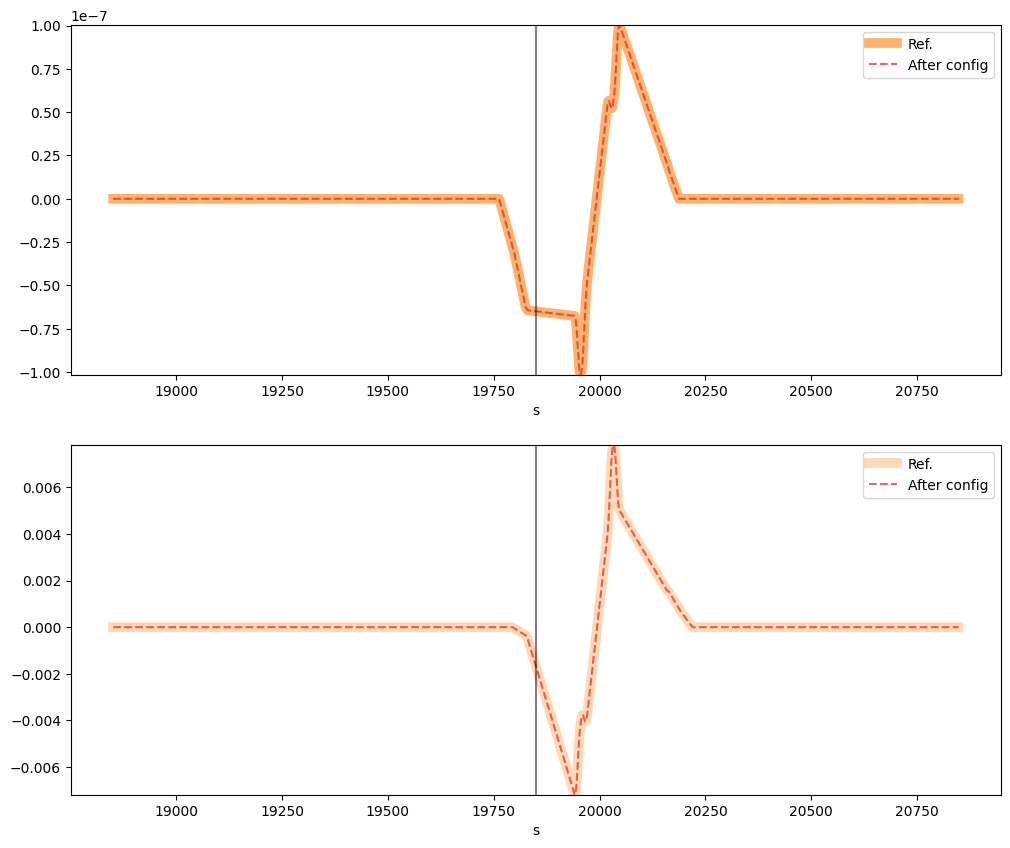

In [3]:

beam = 'b1'
# Activating wires
#===================================================
tracker.vars['enable_qff'] = 0

# tracker.vars[f"bbcw_rw_ip5.b1"] = 12.5e-3
# tracker.vars[f"bbcw_i_ip5.b1"]  = 350

# tracker.vars[f"bbcw_rw_ip1.b1"] = 9.25e-3
# tracker.vars[f"bbcw_i_ip1.b1"]  = 350

tracker.vars[f"bbcw_rw_ip5.b1"] = 25e-3
tracker.vars[f"bbcw_i_ip5.b1"]  = 350

tracker.vars[f"bbcw_rw_ip1.b1"] = 25e-3
tracker.vars[f"bbcw_i_ip1.b1"]  = 350

xf.configure_orbit_dependent_parameters_for_bb(tracker,particle_on_co=particle_on_tracker_co)
co_post  = tracker.twiss().to_pandas(index='name')[['s','x','y']]


# Linking post with current:
for wire in run3_wires:
    _IP = f'ip{wire.split(".")[1][-1]}'
    tracker.element_refs[wire].post_subtract_px = (tracker.vars[f"bbcw_i_{_IP}.{beam}"]/350)* tracker.element_refs[wire].post_subtract_px._value
    tracker.element_refs[wire].post_subtract_py = (tracker.vars[f"bbcw_i_{_IP}.{beam}"]/350)* tracker.element_refs[wire].post_subtract_py._value

ROI = np.abs(co_ref['s'] - co_ref.loc[wire,'s'])<1000

plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.plot(co_ref[ROI].s,co_ref[ROI].x    ,'-',alpha=0.6,color= 'C1',lw=7,label='Ref.')
#plt.plot(co_prior[ROI].s,co_prior[ROI].x,'-',alpha=0.7,color= 'C0',lw=3,label='Before config')
plt.plot(co_post[ROI].s,co_post[ROI].x  ,'--',alpha=0.7,color= 'C3',label='After config')
plt.xlabel('s')
plt.axvline(co_ref.loc[wire,'s'],color='k',alpha=0.5)
plt.ylim([np.min(co_ref[ROI].x),np.max(co_ref[ROI].x)])
plt.legend()

plt.subplot(2,1,2)
plt.plot(co_ref[ROI].s,co_ref[ROI].y    ,'-',alpha=0.3,color= 'C1',lw=7,label='Ref.')
#plt.plot(co_prior[ROI].s,co_prior[ROI].y,'-',alpha=0.7,color= 'C0',lw=3,label='Before config')
plt.plot(co_post[ROI].s,co_post[ROI].y  ,'--',alpha=0.7,color= 'C3',label='After config')
plt.xlabel('s')
plt.axvline(co_ref.loc[wire,'s'],color='k',alpha=0.5)
plt.ylim([np.min(co_ref[ROI].y),np.max(co_ref[ROI].y)])
plt.legend()






    


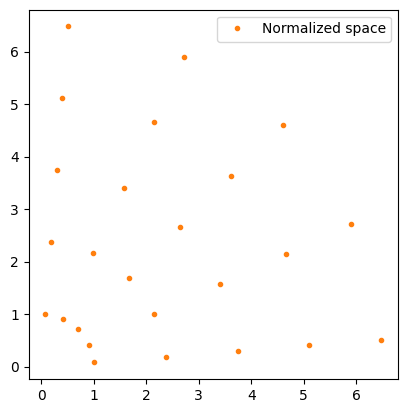

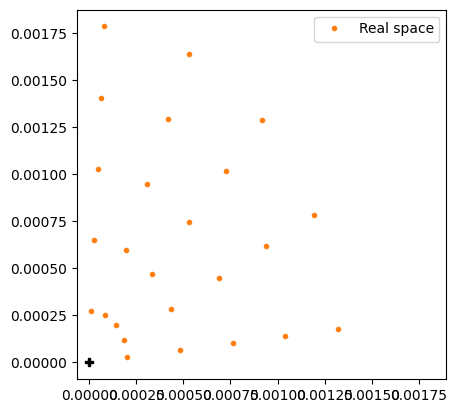

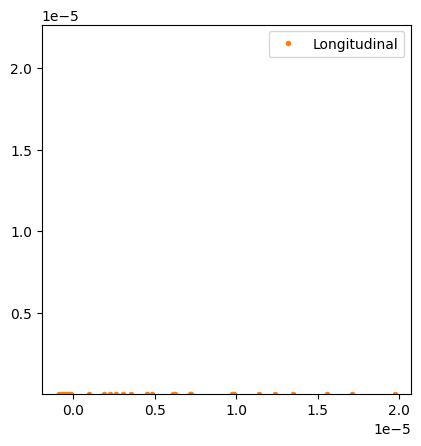

In [4]:


def generate_particles(method='6d'):
    # Generating Coord grid
    #=========================================================
    coordinates = phys.polar_grid(  r_sig     = np.linspace(1,6.5,5),
                                    theta_sig = np.linspace(0.05*np.pi/2,0.95*np.pi/2,5),
                                    emitt     = [B1.emittx,B1.emitty])
    coordinates.insert(0,'delta',0)
    group_length = len(coordinates)

    # Generation
    p0        = xp.Particles(mass0=tracker.line.particle_ref.mass0, q0 = tracker.line.particle_ref.q0 , p0c=tracker.line.particle_ref.p0c)
    particles = xp.build_particles( method       = method,
                                    particle_ref = p0,
                                    tracker      = tracker,
                                    x_norm       = coordinates['x_sig'].values, 
                                    px_norm      = None, 
                                    y_norm       = coordinates['y_sig'].values, 
                                    py_norm      = None,
                                    zeta         = None,
                                    delta        = coordinates['delta'].values,
                scale_with_transverse_norm_emitt = [B1.emittx_n,B1.emitty_n])
    
    return particles,coordinates



particles0,coordinates0 = generate_particles()


plt.figure()
plt.plot(coordinates0['x_sig'],coordinates0['y_sig'],'.',color='C1',label='Normalized space')
plt.axis('square')
plt.legend()


_tmp_twiss = pd.DataFrame(tracker.twiss(),columns = df_columns)
_tmp_twiss.set_index('name',inplace=True)
plt.figure()
plt.plot(particles0.x   ,particles0.y    ,'.',color='C1',label='Real space')
plt.plot(_tmp_twiss.loc['ip3','x'],_tmp_twiss.loc['ip3','y'],'P',color='k')
plt.axis('square')
plt.legend()


plt.figure()
plt.plot(particles0.zeta   ,particles0.delta    ,'.',color='C1',label='Longitudinal')
plt.axis('square')
plt.legend()



---

# Tracking

In [5]:


# Matching
#===================================
for _ip in ['ip1','ip5','ip2','ip8']:
    tracker.vars[f'{_ip}_bblr_ON'] = 0
    tracker.vars[f'{_ip}_bbho_ON'] = 0

tracker.vars['all_oct_ON']   = 1
tracker.vars['all_sext_ON']  = 1

tracker.vars['enable_qff'] = 0
for IP in ['ip1','ip5']:
    tracker.vars[f"bbcw_i_{IP}.{beam}"]  = 0

tw_final = tracker.twiss()
Qx_0,Qy_0 = np.round(np.mod(tw_final['qx'],1),4),np.round(np.mod(tw_final['qy'],1),4)
print('\nInitial twiss parameters')
print(f"Qx = {tw_final['qx']:.5f} Qy = {tw_final['qy']:.5f} "
      f"Q'x = {tw_final['dqx']:.5f} Q'y = {tw_final['dqy']:.5f}")
print(40*'-')


tracker.match(vary=['dqx.b1','dqy.b1'],
    targets = [
        ('qx', 62.31),
        ('qy', 60.32)])
        
tracker.match(vary=['dqpx.b1_sq','dqpy.b1_sq'],
    targets = [
        ('dqx', 15.0),
        ('dqy', 15.0)])





tw_final = tracker.twiss()
Qx_0,Qy_0 = np.round(np.mod(tw_final['qx'],1),4),np.round(np.mod(tw_final['qy'],1),4)
print('\nFinal twiss parameters')
print(f"Qx = {tw_final['qx']:.5f} Qy = {tw_final['qy']:.5f} "
      f"Q'x = {tw_final['dqx']:.5f} Q'y = {tw_final['dqy']:.5f}")
#===================================



Initial twiss parameters
Qx = 62.31000 Qy = 60.32000 Q'x = 15.01113 Q'y = 14.99528
----------------------------------------

Final twiss parameters
Qx = 62.31000 Qy = 60.32000 Q'x = 14.99805 Q'y = 14.99873


In [35]:


# Choosing knobs
#==========================
tracker.vars[f'ip1_bbho_ON'] = 0
tracker.vars[f'ip5_bbho_ON'] = 0

tracker.vars[f'ip1_bblr_ON'] = 0
tracker.vars[f'ip5_bblr_ON'] = 0

tracker.vars['all_oct_ON']   = 0
tracker.vars['all_sext_ON']  = 1

tracker.vars['enable_qff'] = 0
for IP in ['ip1','ip5']:
    tracker.vars[f"bbcw_i_{IP}.{beam}"]  = 0
#==========================

particles,coordinates = generate_particles(method = '4d')
particles.zeta *= 0
particles.delta *= 0
tracked_ref4D = xPlus.Tracking(tracker, particles, n_turns = 1024,method='4D',progress=True)




# Choosing knobs
#==========================
tracker.vars[f'ip1_bbho_ON'] = 0
tracker.vars[f'ip5_bbho_ON'] = 0

tracker.vars[f'ip1_bblr_ON'] = 0
tracker.vars[f'ip5_bblr_ON'] = 0

tracker.vars['all_oct_ON']   = 1
tracker.vars['all_sext_ON']  = 1


tracker.vars['enable_qff'] = 0
tracker.vars[f"bbcw_i_ip1.b1"]  = 0
tracker.vars[f"bbcw_i_ip5.b1"]  = 0

tracker.vars['oct_I'] = +300#300/10
#==========================


particles,coordinates = generate_particles(method = '4d')
particles.zeta *= 0
particles.delta *= 0
tracked4D_IP1 = xPlus.Tracking(tracker, particles, n_turns = 1024,method='4D',progress=True)



# Choosing knobs
#==========================
tracker.vars[f'ip1_bbho_ON'] = 0
tracker.vars[f'ip5_bbho_ON'] = 0

tracker.vars[f'ip1_bblr_ON'] = 0
tracker.vars[f'ip5_bblr_ON'] = 0

tracker.vars['all_oct_ON']   = 1
tracker.vars['all_sext_ON']  = 1

tracker.vars['enable_qff'] = 0
tracker.vars[f"bbcw_i_ip1.b1"]  = 0
tracker.vars[f"bbcw_i_ip5.b1"]  = 0

tracker.vars['oct_I'] = -300#300/10
#==========================


particles,coordinates = generate_particles(method = '4d')
particles.zeta *= 0
particles.delta *= 0
tracked4D_IP5 = xPlus.Tracking(tracker, particles, n_turns = 1024,method='4D',progress=True)




# Try zeroing longitudinal
#particles.zeta *= 0
#particles.delta *= 0

#trackTwiss = pd.DataFrame(tracker.twiss(),columns = df_columns)
#trackTwiss.set_index('name',inplace=True)





generating ./f6e3cac2001f4b569e4c301a1ff7cd3c.c
the current directory is '/home/phbelang/abp/BBStudies/Examples'
running build_ext
building 'f6e3cac2001f4b569e4c301a1ff7cd3c' extension
gcc -pthread -B /home/phbelang/abp/BBStudies/Executables/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -I/home/phbelang/abp/BBStudies/Executables/py_BB/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include/python3.9 -c f6e3cac2001f4b569e4c301a1ff7cd3c.c -o ./f6e3cac2001f4b569e4c301a1ff7cd3c.o -std=c99 -O3 -Wno-unused-function
gcc -pthread -B /home/phbelang/abp/BBStudies/Executables/miniconda/compiler_compat -shared -Wl,-rpath,/home/phbelang/abp/BBStudies/Executables/miniconda/lib -Wl,-rpath-link,/home/phbelang/abp/BBStudies/Executables/mi

Output()

generating ./77a6f5fef5b9423a8b0f80cb0b7f9526.c
the current directory is '/home/phbelang/abp/BBStudies/Examples'
running build_ext
building '77a6f5fef5b9423a8b0f80cb0b7f9526' extension
gcc -pthread -B /home/phbelang/abp/BBStudies/Executables/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -I/home/phbelang/abp/BBStudies/Executables/py_BB/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include/python3.9 -c 77a6f5fef5b9423a8b0f80cb0b7f9526.c -o ./77a6f5fef5b9423a8b0f80cb0b7f9526.o -std=c99 -O3 -Wno-unused-function
gcc -pthread -B /home/phbelang/abp/BBStudies/Executables/miniconda/compiler_compat -shared -Wl,-rpath,/home/phbelang/abp/BBStudies/Executables/miniconda/lib -Wl,-rpath-link,/home/phbelang/abp/BBStudies/Executables/mi

Output()

generating ./84381941876b4b6f86295edff375a491.c
the current directory is '/home/phbelang/abp/BBStudies/Examples'
running build_ext
building '84381941876b4b6f86295edff375a491' extension
gcc -pthread -B /home/phbelang/abp/BBStudies/Executables/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -I/home/phbelang/abp/BBStudies/Executables/py_BB/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include/python3.9 -c 84381941876b4b6f86295edff375a491.c -o ./84381941876b4b6f86295edff375a491.o -std=c99 -O3 -Wno-unused-function
gcc -pthread -B /home/phbelang/abp/BBStudies/Executables/miniconda/compiler_compat -shared -Wl,-rpath,/home/phbelang/abp/BBStudies/Executables/miniconda/lib -Wl,-rpath-link,/home/phbelang/abp/BBStudies/Executables/mi

Output()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


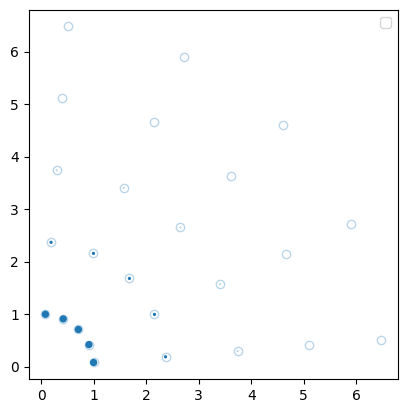

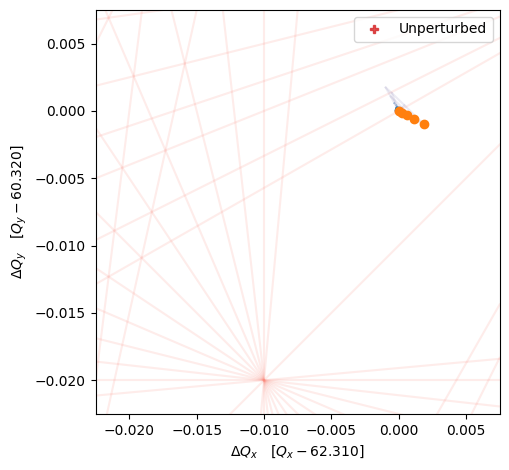

In [42]:
import scipy.stats as sciStat


plt.figure()
plt.plot(coordinates['x_sig'],coordinates['y_sig'],'o',color='C0',mfc='none',alpha=0.3)
plt.scatter(coordinates['x_sig'],coordinates['y_sig'],s = 30*sciStat.norm.pdf(coordinates['r_sig'])/sciStat.norm.pdf(0))
plt.axis('square')
plt.legend()
#plt.savefig('footprint_coordinates.png',format='png',dpi=300)

window    = 0.03
Qx_0,Qy_0 = 0.31, 0.32
Qx_lim    = [Qx_0-3*window/4,Qx_0+window/4]
Qy_lim    = [Qy_0-3*window/4,Qy_0+window/4]

# Plotting

plt.figure()

#---------------
# tracked4D_IP1._tunesMTD     = 'pynaff'
# tracked_ref4D._tunesMTD = 'pynaff'
dQx =tracked4D_IP1.tunes_n['Qx'] - tracked_ref4D.tunes_n['Qx']
dQy =tracked4D_IP1.tunes_n['Qy'] - tracked_ref4D.tunes_n['Qy']

# Scale for scale_strength factor
dQx *= 1
dQy *= 1
#---------------
bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,offset = [-Qx_0,-Qy_0],alpha=0.15,color='salmon')
bbplt.polarmesh(dQx,dQy,alpha=0.1,r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
plt.scatter(dQx,dQy,s = 30*sciStat.norm.pdf(coordinates['r_sig'])/sciStat.norm.pdf(0),zorder=10)
plt.scatter(dQx.loc[ctour_idx],dQy.loc[ctour_idx],c='C1',zorder=10)
plt.plot([0],[0],'P',color='C3',alpha=0.8,label='Unperturbed')



plt.legend(loc='upper right')
plt.axis('square')
plt.xlim(np.array(Qx_lim)-Qx_0)
plt.ylim(np.array(Qy_lim)-Qy_0)
plt.xlabel(rf'$\Delta Q_x\quad [Q_x - {Qx_0+62:.3f}]$')
plt.ylabel(rf'$\Delta Q_y\quad [Q_y - {Qy_0+60:.3f}]$')
plt.tight_layout()
plt.savefig('tuneshift_IP1_4D.png',format='png',dpi=300)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


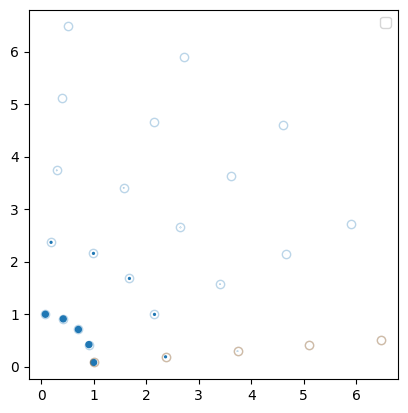

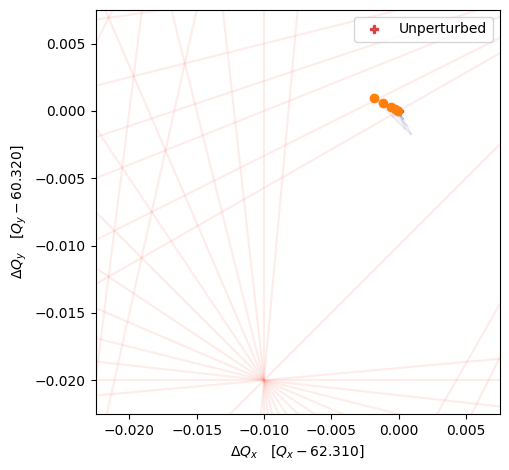

In [40]:
import scipy.stats as sciStat

ctour_idx  = list(coordinates[coordinates['theta_sig'] == np.min(coordinates['theta_sig'])].index)


plt.figure()
plt.plot(coordinates['x_sig'],coordinates['y_sig'],'o',color='C0',mfc='none',alpha=0.3)
plt.scatter(coordinates['x_sig'],coordinates['y_sig'],s = 30*sciStat.norm.pdf(coordinates['r_sig'])/sciStat.norm.pdf(0))
plt.plot(coordinates.loc[ctour_idx,'x_sig'],coordinates.loc[ctour_idx,'y_sig'],'o',color='C1',mfc='none',alpha=0.3)
plt.axis('square')
plt.legend()
#plt.savefig('footprint_coordinates.png',format='png',dpi=300)

window    = 0.03
Qx_0,Qy_0 = 0.31, 0.32
Qx_lim    = [Qx_0-3*window/4,Qx_0+window/4]
Qy_lim    = [Qy_0-3*window/4,Qy_0+window/4]

# Plotting

plt.figure()


#---------------
# tracked4D_IP5._tunesMTD     = 'pynaff'
# tracked_ref4D._tunesMTD = 'pynaff'
dQx =tracked4D_IP5.tunes_n['Qx'] - tracked_ref4D.tunes_n['Qx']
dQy =tracked4D_IP5.tunes_n['Qy'] - tracked_ref4D.tunes_n['Qy']

# Scale for scale_strength factor
dQx *= 1
dQy *= 1
#---------------
bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,offset = [-Qx_0,-Qy_0],alpha=0.15,color='salmon')
bbplt.polarmesh(dQx,dQy,alpha=0.1,r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
plt.scatter(dQx,dQy,s = 30*sciStat.norm.pdf(coordinates['r_sig'])/sciStat.norm.pdf(0),zorder=10)
plt.scatter(dQx.loc[ctour_idx],dQy.loc[ctour_idx],c='C1',zorder=10)
plt.plot([0],[0],'P',color='C3',alpha=0.8,label='Unperturbed')

plt.legend(loc='upper right')
plt.axis('square')
plt.xlim(np.array(Qx_lim)-Qx_0)
plt.ylim(np.array(Qy_lim)-Qy_0)
plt.xlabel(rf'$\Delta Q_x\quad [Q_x - {Qx_0+62:.3f}]$')
plt.ylabel(rf'$\Delta Q_y\quad [Q_y - {Qy_0+60:.3f}]$')
plt.tight_layout()
plt.savefig('tuneshift_IP5_4D.png',format='png',dpi=300)


In [31]:
tracker.element_refs['mo.26l2.b1']._value.to_dict()

{'__class__': 'Multipole',
 'order': 3,
 'inv_factorial_order': 0.16666666666666666,
 'length': 0.32,
 'hxl': 0.0,
 'hyl': 0.0,
 'radiation_flag': 0,
 'knl': array([ 0.        ,  0.        ,  0.        , -0.29134056]),
 'ksl': array([0., 0., 0., 0.])}

In [30]:
tracker.element_refs['mo.33l2.b1']._value.to_dict()

{'__class__': 'Multipole',
 'order': 3,
 'inv_factorial_order': 0.16666666666666666,
 'length': 0.32,
 'hxl': 0.0,
 'hyl': 0.0,
 'radiation_flag': 0,
 'knl': array([ 0.        ,  0.        ,  0.        , -0.29134056]),
 'ksl': array([0., 0., 0., 0.])}

'mo.28l2.b1'

In [58]:
IP1

In [75]:
len(target_oct)

16

In [82]:
for target in target_oct:
    for dep in tracker.vars[target]._find_dependant_targets():
        if isinstance(dep._value,(type(np.array([])))):
            ee = str(dep).split("['")[1].split("']")[0]
            print(target,ee,dep._value)

kof.a12b1 mo.29l2.b1 [0.         0.         0.         2.91340558]
kof.a12b1 mo.31r1.b1 [0.         0.         0.         2.91340558]
kof.a12b1 mo.33r1.b1 [0.         0.         0.         2.91340558]
kof.a12b1 mo.33l2.b1 [0.         0.         0.         2.91340558]
kof.a12b1 mo.29r1.b1 [0.         0.         0.         2.91340558]
kof.a12b1 mo.31l2.b1 [0.         0.         0.         2.91340558]
kof.a12b1 mo.25l2.b1 [0.         0.         0.         2.91340558]
kof.a12b1 mo.25r1.b1 [0.         0.         0.         2.91340558]
kof.a23b1 mo.34r2.b1 [0.         0.         0.         2.91340558]
kof.a23b1 mo.28l3.b1 [0.         0.         0.         2.91340558]
kof.a23b1 mo.26r2.b1 [0.         0.         0.         2.91340558]
kof.a23b1 mo.30l3.b1 [0.         0.         0.         2.91340558]
kof.a23b1 mo.26l3.b1 [0.         0.         0.         2.91340558]
kof.a23b1 mo.32l3.b1 [0.         0.         0.         2.91340558]
kof.a23b1 mo.28r2.b1 [0.         0.         0.         2.91340

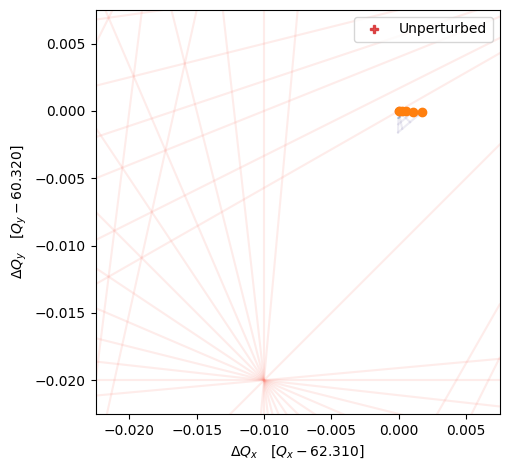

In [83]:

tracker.vars['enable_qff'] = 0
tracker.vars[f"bbcw_i_ip1.b1"]  = 0
tracker.vars[f"bbcw_i_ip5.b1"]  = 0

tracker.vars['oct_I'] = 300#300/10
#==========================


dQx,dQy = np.zeros(len(coordinates)),np.zeros(len(coordinates))
for target in target_oct:
    for dep in tracker.vars[target]._find_dependant_targets():
        if isinstance(dep._value,(type(np.array([])))):
            ee = str(dep).split("['")[1].split("']")[0]
            betx  =  twiss['b1'].loc[ee,'betx'].mean()
            bety  =  twiss['b1'].loc[ee,'bety'].mean()
            k3 = dep._value[3]
            if 'kod' in target:
                k3 *= -1

            _DQx,_DQy = dtune.BBLR_octupole(    Jx   = np.array(coordinates['x_sig'])**2*IP1.b2.emittx/2,
                                                Jy   = np.array(coordinates['y_sig'])**2*IP1.b2.emittx/2,
                                                betx = betx,
                                                bety = bety,
                                                k1   = 0,#k1,
                                                k3   = k3)

            dQx += _DQx
            dQy += _DQy


x_idx  = list(coordinates[coordinates['theta_sig'] == np.min(coordinates['theta_sig'])].index)

bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,offset = [-Qx_0,-Qy_0],alpha=0.15,color='salmon')
bbplt.polarmesh(dQx,dQy,alpha=0.1,r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
plt.scatter(dQx,dQy,s = 30*sciStat.norm.pdf(coordinates['r_sig'])/sciStat.norm.pdf(0),zorder=10)
plt.scatter(dQx[x_idx],dQy[x_idx],c='C1',zorder=10)
plt.plot([0],[0],'P',color='C3',alpha=0.8,label='Unperturbed')

plt.legend(loc='upper right')
plt.axis('square')
plt.xlim(np.array(Qx_lim)-Qx_0)
plt.ylim(np.array(Qy_lim)-Qy_0)
plt.xlabel(rf'$\Delta Q_x\quad [Q_x - {Qx_0+62:.3f}]$')
plt.ylabel(rf'$\Delta Q_y\quad [Q_y - {Qy_0+60:.3f}]$')
plt.tight_layout()

In [9]:
if False:
    OUTFOLDER = 'VS_wire4D_octu'
    tracked4D_IP1.to_pickle(f'{OUTFOLDER}/tracked4D_IP1_far_sf10.pkl')
    tracked4D_IP5.to_pickle(f'{OUTFOLDER}/tracked4D_IP5_far_sf10.pkl')
    # tracked4D.to_pickle(f'{OUTFOLDER}/tracked4D.pkl')
    tracked_ref4D.to_pickle(f'{OUTFOLDER}/tracked4D_wire_far_ref.pkl')
    # coordinates.to_pickle(f'{OUTFOLDER}/coordinates.pkl')